# Big Data Project: Flight Delay Prediction Using Spark Streaming & Kafka

## (1) Data Loading

Flight Dataset: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=flights_sample_3m.csv

### Flight Info
* FL_DATE - Flight Date (yyyymmdd)
* AIRLINE_CODE - Reporting Airline / Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
* DOT_CODE - An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.</td>
* FL_NUMBER - Flight Number

### Locations
* ORIGIN - Origin Airport
* ORIGIN_CITY - Origin Airport, City Name
* DEST - Destination Airport
* DEST_CITY - Destination Airport, City Name

### Departure
* CRS_DEP_TIME - Computer Reservation System Departure Time (local time: hhmm)
* DEP_TIME - Actual Departure Time (local time: hhmm)
* DEP_DELAY - Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

### Takeoff/Landing
* TAXI_OUT - Taxi Out Time, in Minutes
* WHEELS_OFF - Wheels Off Time (local time: hhmm)
* WHEELS_ON - Wheels On Time (local time: hhmm)
* TAXI_IN - Taxi In Time, in Minutes

### Arrival
* CRS_ARR_TIME - Computer Reservation System Arrival Time (local time: hhmm)
* ARR_TIME - Actual Arrival Time (local time: hhmm)
* ARR_DELAY - Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

### Cancellation/Diversion
* CANCELLED - Cancelled Flight Indicator (1=Yes)
* CANCELLATION_CODE - Specifies The Reason For Cancellation
* DIVERTED - Diverted Flight Indicator (1=Yes)

### Flight
* CRS_ELAPSED_TIME - Computer Reservation System Elapsed Time of Flight, in Minutes
* ELAPSED_TIME - Elapsed Time of Flight, in Minutes
* AIR_TIME - Flight Time, in Minutes
* DISTANCE - Distance between airports (miles)

### Delay
* DELAY_DUE_CARRIER - Carrier Delay, in Minutes
* DELAY_DUE_WEATHER - Weather Delay, in Minutes
* DELAY_DUE_NAS - National Air System Delay, in Minutes
* DELAY_DUE_SECURITY - Security Delay, in Minutes
* DELAY_DUE_LATE_AIRCRAFT - Late Aircraft Delay, in Minutes

[1.1] Output: Dataframe Schema

In [1]:
# Setup Spark path
import findspark
findspark.init()

# Initialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv("flight_data.csv", header=True, inferSchema=True)

# Testing Purposes: Show 1st 5 rows of dataframe
# df.show(5)

# Show schema of dataframe
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/24 15:54:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[Stage 1:=============================>                             (1 + 1) / 2]

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

----------------------------------------                                        
Exception happened during processing of request from ('127.0.0.1', 46992)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/hadoop/spark-3.5.4/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/hadoop/spark-3.5.4/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/hadoop/spark-3.5.4/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates

## (2) Data Cleaning/Transformation

[2.1] Output: Showing Null Counts before Cleaning

In [2]:
# Import pyspark SQL functions & ML features
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

# Dropping columns we don't need
columns_to_drop = ['CANCELLATION_CODE', 'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER']
df = df.drop(*columns_to_drop)

# Create a DataFrame with column names and their respective null counts
null_counts = [(col, df.filter(df[col].isNull()).count()) for col in df.columns]
null_df = spark.createDataFrame(null_counts, ["Column", "Null_Count"])

# Show the result
null_df.show(30)

+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|             FL_DATE|         0|
|             AIRLINE|         0|
|        AIRLINE_CODE|         0|
|              ORIGIN|         0|
|         ORIGIN_CITY|         0|
|                DEST|         1|
|           DEST_CITY|         1|
|        CRS_DEP_TIME|         1|
|            DEP_TIME|      6993|
|           DEP_DELAY|      6996|
|            TAXI_OUT|      7087|
|          WHEELS_OFF|      7087|
|           WHEELS_ON|      7186|
|             TAXI_IN|      7186|
|        CRS_ARR_TIME|         1|
|            ARR_TIME|      7186|
|           ARR_DELAY|      7699|
|           CANCELLED|         1|
|            DIVERTED|         1|
|    CRS_ELAPSED_TIME|         3|
|        ELAPSED_TIME|      7699|
|            AIR_TIME|      7699|
|            DISTANCE|         1|
|   DELAY_DUE_CARRIER|    218893|
|   DELAY_DUE_WEATHER|    218893|
|       DELAY_DUE_NAS|    218893|
|  DELAY_DUE_S

In [3]:
# Assuming that if ARR_DELAY or DEP_DELAY are null then either:
# 1) Missing data entries
# 2) Corrupt data entries
# Drop null values
df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

# Filling null values with 0 for these specific columns since there is no delay 
# due to these issues
df = df.fillna({
    'DELAY_DUE_CARRIER': 0, 
    'DELAY_DUE_WEATHER': 0, 
    'DELAY_DUE_NAS': 0, 
    'DELAY_DUE_SECURITY': 0, 
    'DELAY_DUE_LATE_AIRCRAFT': 0
})

In [4]:
# Editing format of the date for easier use
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

# extracting time-based features from scheduled departure time (CRS_DEP_TIME) column
df = df.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df = df.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df = df.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))

# weekend flights most likely have higher likelihood of being delayed so we'll flag these
df = df.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))

[2.2] Output: Basic Numerical Data Summary

In [5]:
# import pandas
import pandas as pd

# Create a list of numeric columns in dataframe
# Not using time based: CRS_DEP_TIME/DEP_TIME, CRS_ARR_TIME/ARR_TIME, CRS_ELAPSED_TIME/ELAPSED_TIME, WHEELS_OFF/WHEELS_ON
# Not using binary based: CANCELLED/DIVERTED
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "AIR_TIME", "DISTANCE",
                "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT",
                "DEP_HOUR", "DEP_DAY_OF_WEEK", "DEP_MONTH", "IS_WEEKEND"]

# Testing Purposes: Show list of numeric columns of dataframe
# print(numeric_cols)

# Get the basic statistics of the DataFrame for the numeric columns
df_stats = df.select([F.round(F.col(c), 2).alias(c) for c in numeric_cols]).describe()

# Convert the result to a Pandas DataFrame
df_stats_pd = df_stats.toPandas()

# Round the numeric values (except for the 'summary' row)
df_stats_pd.iloc[1:, 1:] = df_stats_pd.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').round(2)

# Set the 'summary' features as the index
df_stats_pd.set_index('summary', inplace=True)

print(df_stats_pd)

25/03/24 15:56:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

        DEP_DELAY TAXI_OUT TAXI_IN ARR_DELAY AIR_TIME DISTANCE  \
summary                                                          
count      258676   258676  258676    258676   258676   258676   
mean        10.14    16.64    7.67      4.34   112.18   809.64   
stddev      49.27     9.19    6.21      51.4    69.53   587.51   
min         -68.0      1.0     1.0     -81.0      8.0     30.0   
max        1732.0    172.0   222.0    1741.0    661.0   5095.0   

        DELAY_DUE_CARRIER DELAY_DUE_WEATHER DELAY_DUE_NAS DELAY_DUE_SECURITY  \
summary                                                                        
count              258676            258676        258676             258676   
mean                 4.57              0.72          2.41               0.03   
stddev              31.76             14.67         15.21               1.41   
min                   0.0               0.0           0.0                0.0   
max                1732.0            1398.0        1468.0

In [6]:
# severe delay for flights delayed over one hour
df = df.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= 60, 1).otherwise(0))

## (3) Visualization

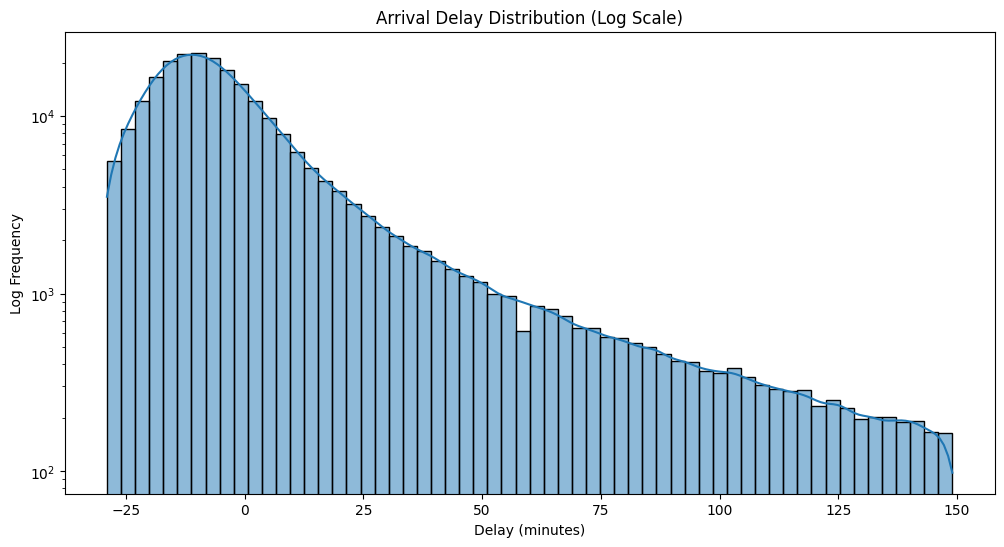

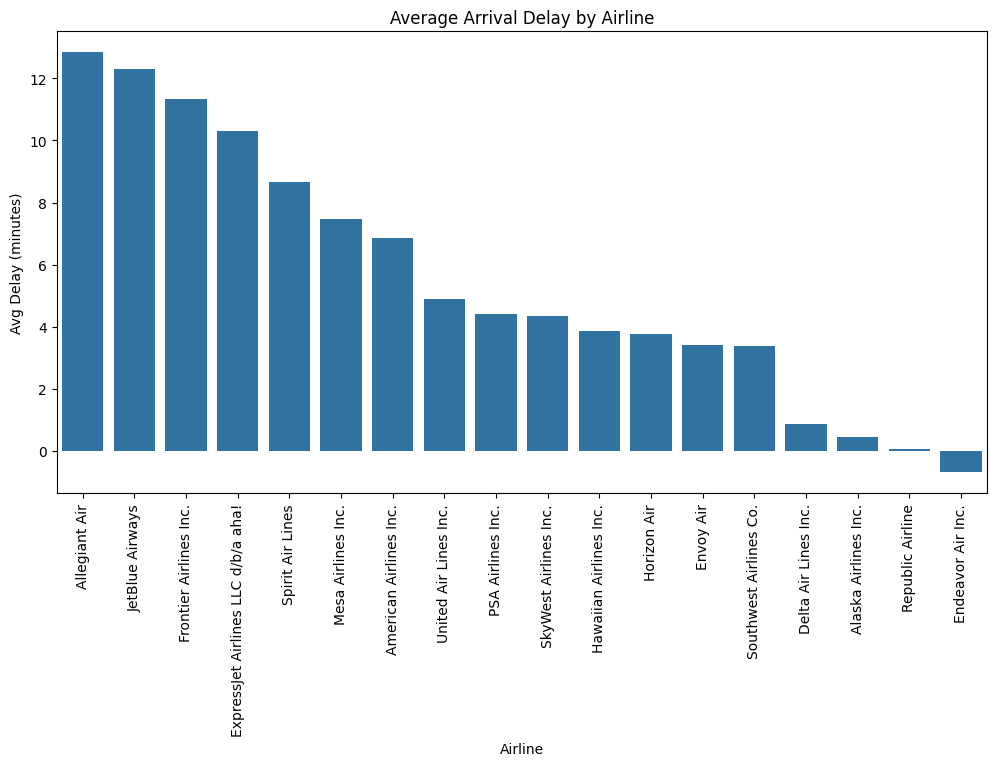

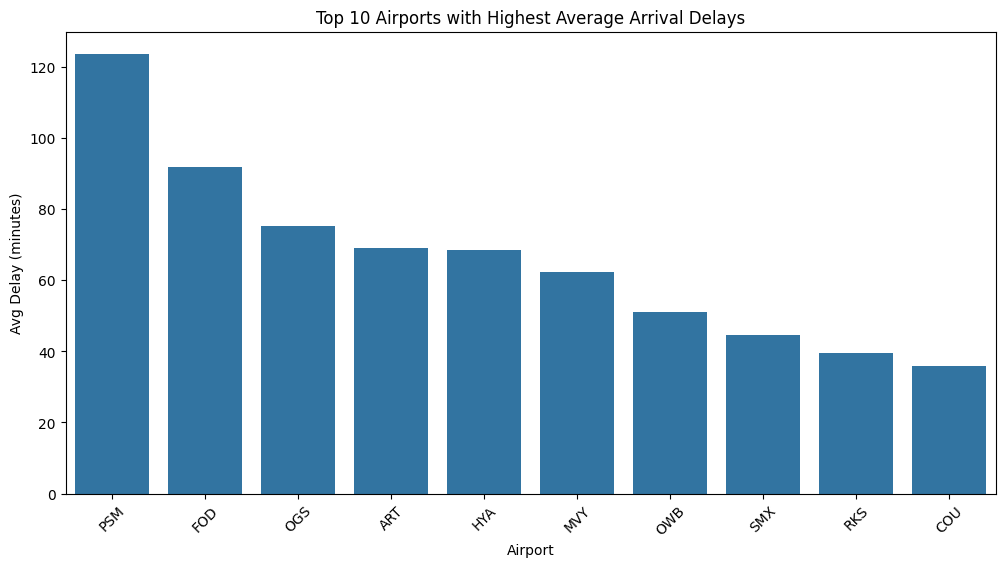

ERROR:root:Exception while sending command.                         (0 + 2) / 2]
Traceback (most recent call last):
  File "/home/hadoop/spark-3.5.4/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hadoop/spark-3.5.4/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/hadoop/spark-3.5.4/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/hadoop/spark-3.5.4/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", 

ConnectionRefusedError: [Errno 111] Connection refused

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pd = df.select("ARR_DELAY", "AIRLINE", "ORIGIN").toPandas()

# Arrival Delay Distribution
pd_df_filtered = df_pd[(df_pd["ARR_DELAY"] > -30) & (df_pd["ARR_DELAY"] < 150)]

plt.figure(figsize=(12, 6))
sns.histplot(pd_df_filtered["ARR_DELAY"].dropna(), bins=60, kde=True)
plt.yscale("log")
plt.title("Arrival Delay Distribution (Log Scale)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Log Frequency")
plt.show()

# Average Arrival Delay by Airline
airline_delays = df_pd.groupby("AIRLINE")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="ARR_DELAY", data=airline_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (minutes)")
plt.show()

# Top 10 Airports with Highest Delays
airport_delays = df_pd.groupby("ORIGIN")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="ORIGIN", y="ARR_DELAY", data=airport_delays)
plt.title("Top 10 Airports with Highest Average Arrival Delays")
plt.xlabel("Airport")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(rotation=45)
plt.show()

# Flight Delays by Origin Airport
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays = airport_delays.sort_values("AvgDelay", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.heatmap(airport_delays.set_index("ORIGIN"), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Flight Delays by Origin Airport")
plt.xlabel("Avg Delay (minutes)")
plt.ylabel("Airport")
plt.show()



## (4) Prepare Features and Labels

In [15]:
# encoding the categorical variables and adding index/onehot after them in the columns
categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}OneHot") for col in categorical_cols]

# using vector assembler on numerical data
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# making the final assembler
final_assembler = VectorAssembler(
    inputCols=["AIRLINEOneHot", "ORIGINOneHot", "DESTOneHot", "scaled_features"],
    outputCol="final_features"
)

# pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, final_assembler])
processed_df = pipeline.fit(df).transform(df)

processed_df.select("final_features", "SEVERE_DELAY").show(5)

+-----------------------+------------+
|final_features_extended|SEVERE_DELAY|
+-----------------------+------------+
|   (789,[4,40,414,77...|           0|
|   (789,[1,30,404,77...|           0|
|   (789,[4,20,409,77...|           0|
|   (789,[1,30,410,77...|           0|
|   (789,[11,26,397,7...|           0|
+-----------------------+------------+
only showing top 5 rows



## (5) Initial Model Creation

In [16]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select the final features and label
model_df = final_df.select("final_features_extended", "SEVERE_DELAY") \
                                .withColumnRenamed("final_features_extended", "features") \
                                .withColumnRenamed("SEVERE_DELAY", "label")

sample_df = model_df.sample(withReplacement=False, fraction=0.1, seed=101)

# Train/Test split
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=101)

# RandomForest model training
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_df)

# Predictions on test set
predictions = rf_model.transform(test_df)

# Evaluate accuracy
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy (AUC): {accuracy:.4f}")


25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_4 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_4 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_3 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_3 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_5 in memory! (computed 47.1 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_5 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_1 in memory! (computed 19.1 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_1 to disk instead.
25/03/23 19:32:47 WARN MemoryStore: Not enough space to cache rdd_678_6 in memory! (computed 31.3 MiB so far)
25/03/23 19:32:47 WARN BlockManager: Persisting block rdd_678_6 to disk instead.
25/03/23 19:32:48 WARN MemoryStore: Not enoug

Test Accuracy (AUC): 0.9994
